<a href="https://colab.research.google.com/github/sskyau/stanford-dogs-classification-models/blob/main/EfficienctNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Environment Initialisation**

##1.1 Import libraries

In [1]:
!pip install --upgrade pip
!pip install tensorflow-datasets
!pip install tensorflow_data_validation[visualization]==1.8.0 tensorflow==2.8
!pip install keract
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 4.3 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 668.3/668.3 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 14.1 MB/s eta 0:00:00
  Preparing metadat

In [1]:
# tf/keras
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
import tensorflow_data_validation as tfdv
import tensorflow_datasets as tfds

# sklearn
from sklearn.model_selection import train_test_split
from skimage.io import imread
from sklearn.model_selection import KFold, StratifiedKFold

# utlity
import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from collections import Counter


%load_ext tensorboard

##1.2 Check connection to GPU and drive

In [2]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [3]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


##1.3 Declare constant variables

In [5]:
IMG_SIZE = 224
NUM_BREEDS = 120
CP_DIR = '/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENB0/'

#**2. Load dataset**

##2.1 Load and visualise data

In [6]:
(train, val, test), info = tfds.load(name="stanford_dogs", 
                                     split=['train[:80%]+test[:80%]','train[80%:90%]+test[80%:90%]', 'train[90%:]+test[90%:]'],
                                     shuffle_files=True,
                                     as_supervised=True, # tuple instead of dictionary
                                     with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIAM0YL/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteIAM0YL/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [7]:
class_labels = info.features['label'].int2str

print('Number of classes: ', info.features['label'].num_classes)
print()
print('Number of samples:')
print('Training set: ', len(train))
print('Validation set: ', len(val))
print('Testing set: ', len(test))
print()
print(info)

Number of classes:  120

Number of samples:
Training set:  16464
Validation set:  2058
Testing set:  2058

tfds.core.DatasetInfo(
    name='stanford_dogs',
    full_name='stanford_dogs/0.2.0',
    description="""
    The Stanford Dogs dataset contains images of 120 breeds of dogs from around
    the world. This dataset has been built using images and annotation from
    ImageNet for the task of fine-grained image categorization. There are
    20,580 images, out of which 12,000 are used for training and 8580 for
    testing. Class labels and bounding box annotations are provided
    for all the 12,000 images.
    """,
    homepage='http://vision.stanford.edu/aditya86/ImageNetDogs/main.html',
    data_path='~/tensorflow_datasets/stanford_dogs/0.2.0',
    file_format=tfrecord,
    download_size=778.12 MiB,
    dataset_size=744.72 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
      

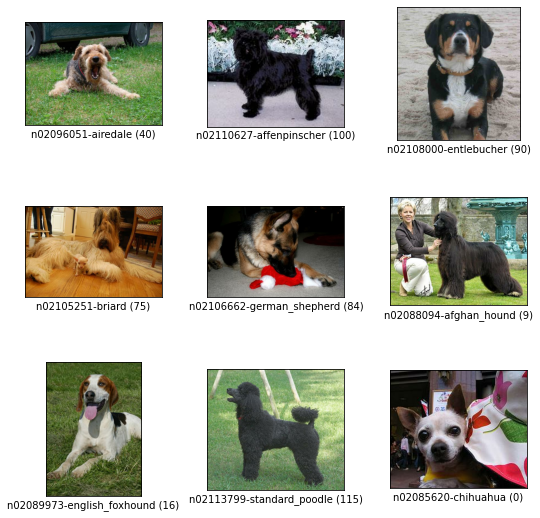

In [ ]:
fig = tfds.show_examples(train, info)

##2.2 Retrieve breed list

In [ ]:
breed_list = []

for filename in info.features['label'].names:
  separator = [i for i, letter in enumerate(filename) if letter == '-']
  breed_list.append(filename[separator[0]+1:])

print(breed_list)

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

##2.3 Visualise dataset distributions

In [ ]:
train_labels, train_counts = np.unique(np.fromiter(train.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Training set class distribution")
sns.barplot(x = train_counts, y = train_labels, orient='h') 

In [ ]:
val_labels, val_counts = np.unique(np.fromiter(val.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = val_counts, y = val_labels, orient='h') 

In [ ]:
test_labels, test_counts = np.unique(np.fromiter(test.map(lambda x, y: y), np.int32), 
                                       return_counts=True)

In [ ]:
sns.set(rc={'figure.figsize':(8,20)})
plt.xlabel('Counts')
plt.ylabel('Labels')
plt.title("Validation set class distribution")
sns.barplot(x = test_counts, y = test_labels, orient='h') 

#**3. Modelling**

##3.1 Preprocessing Layers

In [9]:
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
BATCH_SIZE = 64
RANDOM_SEED = 43

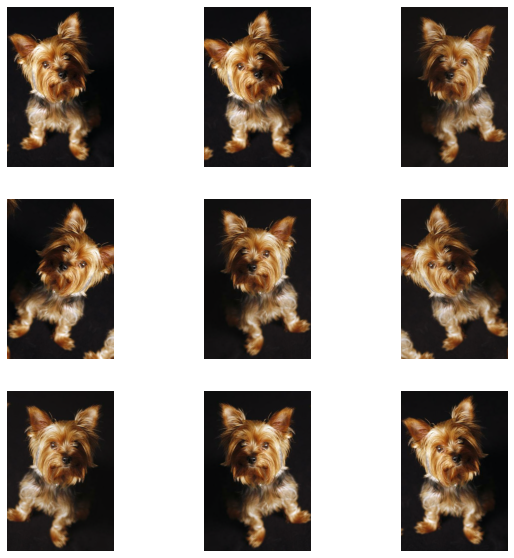

In [10]:
img_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal"),
                                        layers.RandomRotation(0.1),
                                        layers.RandomContrast(factor=0.1),
                                        ])

# Visualize some augmentations

ex_img, label = next(iter(train))
ex_img = tf.cast(ex_img, tf.float32) / 255.

img_batch = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
 
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_img = img_augmentation(img_batch, training=True)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_img[0])
  plt.axis("off")

In [11]:
# Efficientnet takes input images of shape (224, 224, 3) with range [0,255] --> normalisation not needed
# reference: https://keras.io/api/applications/efficientnet/#efficientnetb0-function

def one_hot(image, label):
  label = tf.one_hot(label,NUM_BREEDS)
  return image, label

def resize(image, label):
  image = tf.image.resize(images=image, size=[IMG_SIZE, IMG_SIZE])
  return image, label

# Resize and one-hot encode all datasets

ds_train = train.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(info.splits['train'].num_examples)
ds_train = ds_train.batch(BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)


ds_val = val.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE, drop_remainder=True)
ds_val = ds_val.cache()
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)


ds_test = test.map(one_hot, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(resize, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE, drop_remainder=True)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)


In [16]:
def create_model():
  inputs = Input(shape=INPUT_SHAPE)
  x = img_augmentation(inputs)
  ENB0_base = tf.keras.applications.EfficientNetB0(input_tensor=x,
                                                input_shape=INPUT_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  ENB0_base.trainable = False

  x = GlobalAveragePooling2D()(ENB0_base.output)
  x = layers.BatchNormalization()(x)
  x = Dense(1280, activation='relu', kernel_initializer=tf.keras.initializers.GlorotNormal(RANDOM_SEED), bias_initializer='zeros')(x)
  x = layers.BatchNormalization()(x)
  outputs = Dense(NUM_BREEDS, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

  return Model(inputs=inputs, outputs=outputs)

In [17]:
ENB0_model = create_model()
ENB0_model.compile(optimizer=tf.keras.optimizers.Adam(1e-2),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ENB0_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['sequential[2][0]']             
                                                                                              

In [18]:
EPOCHS = 45
CP_PATH = CP_DIR+'/FE/ENB0-{epoch:02d}.h5'

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)
cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

ENB0_history = ENB0_model.fit(ds_train, 
                    epochs=EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

# save the model if results are satisfactory
ENB0_model.save(CP_PATH+'/model/ENB0.h5')

Epoch 1/45
257/257 [==============================] - 58s 153ms/step - loss: 2.1254 - accuracy: 0.5914 - top_k_categorical_accuracy: 0.8663 - val_loss: 0.8253 - val_accuracy: 0.7495 - val_top_k_categorical_accuracy: 0.9688
Epoch 2/45
257/257 [==============================] - 36s 138ms/step - loss: 0.8854 - accuracy: 0.7377 - top_k_categorical_accuracy: 0.9556 - val_loss: 0.7451 - val_accuracy: 0.7783 - val_top_k_categorical_accuracy: 0.9751
Epoch 3/45
257/257 [==============================] - 35s 136ms/step - loss: 0.7557 - accuracy: 0.7687 - top_k_categorical_accuracy: 0.9686 - val_loss: 0.7630 - val_accuracy: 0.7720 - val_top_k_categorical_accuracy: 0.9771
Epoch 4/45
257/257 [==============================] - 35s 135ms/step - loss: 0.6937 - accuracy: 0.7859 - top_k_categorical_accuracy: 0.9763 - val_loss: 0.7629 - val_accuracy: 0.7778 - val_top_k_categorical_accuracy: 0.9683
Epoch 5/45
257/257 [==============================] - 35s 135ms/step - loss: 0.6311 - accuracy: 0.8038 - top

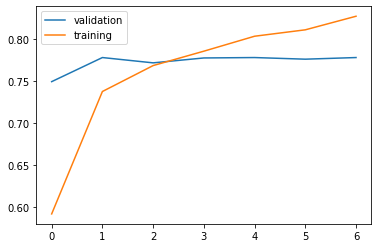

In [19]:
plt.plot(ENB0_history.history['val_accuracy'], label='validation')
plt.plot(ENB0_history.history['accuracy'], label='training')
plt.legend()
plt.show()

In [21]:
logname = CP_DIR + 'FE.csv'

df_fe_history = pd.DataFrame.from_dict(ENB0_history.history) 
df_fe_history.to_csv(logname, index = False, header=True)

# 3.3 Finetuning

In [22]:
def print_trainable(model):
  for layer_id, layer in enumerate(model.layers):
    print(layer_id,' ' , layer.name, ": ", layer.trainable)

In [23]:
ft_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENB0/FE/ENB0-02.h5')

def unfreeze(model, start_layer, end_layer):
  for layer_id, layer in enumerate(model.layers):
    if layer_id >= start_layer and layer_id <= end_layer:
      if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

unfreeze(ft_model, 0, len(ft_model.layers)-1)

In [24]:
print_trainable(ft_model)

0   input_3 :  True
1   sequential :  True
2   rescaling_2 :  True
3   normalization_2 :  True
4   stem_conv_pad :  True
5   stem_conv :  True
6   stem_bn :  False
7   stem_activation :  True
8   block1a_dwconv :  True
9   block1a_bn :  False
10   block1a_activation :  True
11   block1a_se_squeeze :  True
12   block1a_se_reshape :  True
13   block1a_se_reduce :  True
14   block1a_se_expand :  True
15   block1a_se_excite :  True
16   block1a_project_conv :  True
17   block1a_project_bn :  False
18   block2a_expand_conv :  True
19   block2a_expand_bn :  False
20   block2a_expand_activation :  True
21   block2a_dwconv_pad :  True
22   block2a_dwconv :  True
23   block2a_bn :  False
24   block2a_activation :  True
25   block2a_se_squeeze :  True
26   block2a_se_reshape :  True
27   block2a_se_reduce :  True
28   block2a_se_expand :  True
29   block2a_se_excite :  True
30   block2a_project_conv :  True
31   block2a_project_bn :  False
32   block2b_expand_conv :  True
33   block2b_expand_bn 

In [25]:
ft_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

ft_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, None, None,   0           ['input_3[0][0]']                
                                3)                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['sequential[0][0]']             
                                                                                              

In [26]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5,
                                               mode='max', 
                                               verbose=True)

CP_PATH = CP_DIR+'/FT/ENB0-{epoch:02d}.h5'

cp_callback = ModelCheckpoint(
    filepath=CP_PATH,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

FT_EPOCHS = 30
ft_history = ft_model.fit(ds_train, 
                    epochs=FT_EPOCHS,
                    validation_data = ds_val,
                    callbacks=[cp_callback, es_callback])

Epoch 1/30
257/257 [==============================] - 173s 642ms/step - loss: 0.5895 - accuracy: 0.8164 - top_k_categorical_accuracy: 0.9818 - val_loss: 0.6007 - val_accuracy: 0.8091 - val_top_k_categorical_accuracy: 0.9814
Epoch 2/30
257/257 [==============================] - 162s 632ms/step - loss: 0.4986 - accuracy: 0.8442 - top_k_categorical_accuracy: 0.9848 - val_loss: 0.5692 - val_accuracy: 0.8145 - val_top_k_categorical_accuracy: 0.9819
Epoch 3/30
257/257 [==============================] - 162s 629ms/step - loss: 0.4469 - accuracy: 0.8625 - top_k_categorical_accuracy: 0.9884 - val_loss: 0.5633 - val_accuracy: 0.8140 - val_top_k_categorical_accuracy: 0.9834
Epoch 4/30
257/257 [==============================] - 162s 631ms/step - loss: 0.4205 - accuracy: 0.8715 - top_k_categorical_accuracy: 0.9898 - val_loss: 0.5463 - val_accuracy: 0.8223 - val_top_k_categorical_accuracy: 0.9854
Epoch 5/30
257/257 [==============================] - 163s 634ms/step - loss: 0.3993 - accuracy: 0.8765 

#3.4 Testing

In [27]:
best_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Colab Notebooks/Dissertation/cp/ENB0/FT/ENB0-17.h5')

In [28]:
best_model.evaluate(ds_test)

32/32 [==============================] - 6s 140ms/step - loss: 0.5713 - accuracy: 0.8296 - top_k_categorical_accuracy: 0.9790


[0.5712807178497314, 0.82958984375, 0.97900390625]